In [1]:
#1 Clip the land use map into tiles
#2 Clip the NAIP images into tiles
#3 Split the data into two major componments, training and testing

In [2]:
#!pip install path
#!pip install rasterio
#!pip install shapely

In [5]:
import os, os.path
from path import Path
import shutil
import rasterio as rio
import rasterio
from rasterio.windows import get_data_window
from rasterio.windows import Window
import rasterio.mask
import json
from shapely.geometry import Polygon
import random
import numpy as np
import argparse

In [6]:
#1. Clip the land use/cover map

In [7]:
def raster2tiles(input_value_raster, tile_width_in, tile_height_in, outfolder): 
    '''This is function is used to clip the raster data into many smaller 
    fixed size of tiles
    
    Parameter: 
        input_value_raster: the filename of the input raster
        tile_width_in: the specified tile width
        tile_height_in: the specified tile height
        outfolder: the ouput dsm folder
    '''
    
    lu_dataset = rasterio.open(input_value_raster)
    lu_img = lu_dataset.read()
    
    # height and width of the raster
    height, width = lu_dataset.shape

    # split the large raser into number of tiles, tile size is 2000*2000
    tile_width = tile_width_in
    tile_height = tile_height_in

    tile_num_col = int(width/tile_width + 0.5)
    tile_num_row = int(height/tile_height + 0.5)

    # the output folder
    if not os.path.exists(outfolder): os.mkdir(outfolder)
    
    # create each tile
    for i in range(tile_num_row):
        # re-initiate the tile width when reach the right boundary
        tile_width = tile_width_in
        row_start = i*tile_height

        # loop each column
        for j in range(tile_num_col):
            print('The i and j is:', i, j)
            tilename = os.path.join(outfolder, 'row%s-col%s.tif'%(i, j))
            
            col_start = j*tile_width
            row_end = (i + 1)*tile_height
            col_end = (j + 1)*tile_width
            
            # deal with the right boundary
            if row_end > height - 1: tile_height = height - row_start
            if col_end > width - 1: tile_width = width - col_start
            
            # window = get_data_window(lu_dataset.read(1, masked=True))
            window = Window(col_off=col_start, row_off=row_start, width=tile_width, height=tile_height)
            
            kwargs = lu_dataset.meta.copy()
            kwargs.update({
                'height': window.height,
                'width': window.width,
                'transform': rasterio.windows.transform(window, lu_dataset.transform)})
            
            img_window = lu_dataset.read(window=window)
            zero_ratio = np.sum(img_window == 0) / img_window.size
            if zero_ratio > 0.4: continue# filter nodata>40% tiles

            with rasterio.open(tilename, 'w', **kwargs) as dst:
                dst.write(img_window)

In [8]:
landcover_file = 'data/LU2023.tif'
naip_file = 'data/naip2023.tif'

# configure the training data folder
folder1 = 'data/dataset'
if not os.path.exists(folder1): os.mkdir(folder1)
foldertraining = os.path.join(folder1, 'trainning')
if not os.path.exists(foldertraining): os.mkdir(foldertraining)
train_label_folder = os.path.join(foldertraining, 'labels')
if not os.path.exists(train_label_folder): os.mkdir(train_label_folder)

tile_width = 512
tile_height = 512

raster2tiles(landcover_file, tile_width, tile_height, train_label_folder)

The i and j is: 0 0
The i and j is: 0 1
The i and j is: 0 2
The i and j is: 0 3
The i and j is: 0 4
The i and j is: 0 5
The i and j is: 0 6
The i and j is: 0 7
The i and j is: 0 8
The i and j is: 0 9
The i and j is: 0 10
The i and j is: 0 11
The i and j is: 0 12
The i and j is: 0 13
The i and j is: 0 14
The i and j is: 0 15
The i and j is: 0 16
The i and j is: 0 17
The i and j is: 0 18
The i and j is: 0 19
The i and j is: 0 20
The i and j is: 0 21
The i and j is: 0 22
The i and j is: 0 23
The i and j is: 0 24
The i and j is: 0 25
The i and j is: 0 26
The i and j is: 0 27
The i and j is: 0 28
The i and j is: 0 29
The i and j is: 0 30
The i and j is: 0 31
The i and j is: 0 32
The i and j is: 0 33
The i and j is: 0 34
The i and j is: 0 35
The i and j is: 0 36
The i and j is: 0 37
The i and j is: 0 38
The i and j is: 0 39
The i and j is: 0 40
The i and j is: 0 41
The i and j is: 0 42
The i and j is: 0 43
The i and j is: 0 44
The i and j is: 0 45
The i and j is: 0 46
The i and j is: 0 47
Th

In [21]:
tilefile = os.path.join(train_label_folder, 'row80-col64.tif')
os.path.exists(tilefile)

True

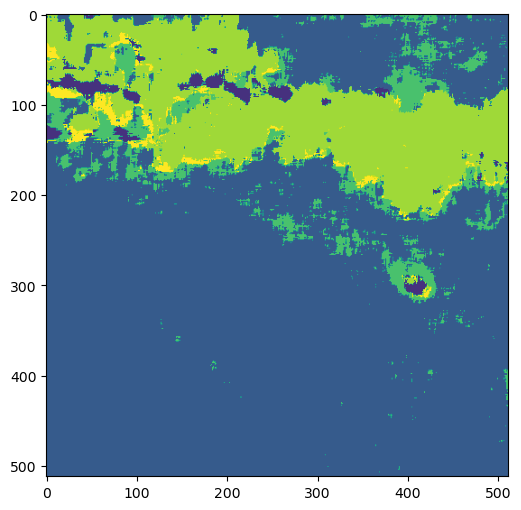

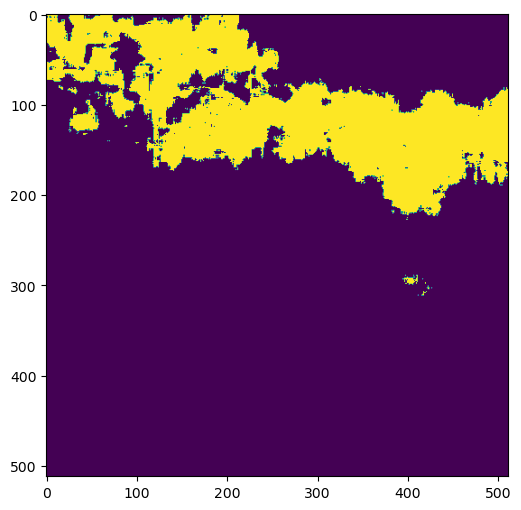

In [22]:
from matplotlib import pyplot as plt

tilefile = os.path.join(train_label_folder, 'row80-col64.tif')
lu_dataset = rasterio.open(tilefile)
lu_img = lu_dataset.read()
lu_img = lu_img.reshape(lu_img.shape[1], lu_img.shape[2])

plt.figure(figsize=(6, 6))
plt.imshow(lu_img)

plt.figure(figsize=(6, 6))
plt.imshow(lu_img == 6) # buildings

In [11]:
#2. Cut the NAIP into tiles

In [12]:
def naip2tiles(naip_file, lu_folder, naip_tile_folder):
    '''
    Clip the NAIP tiles into tiles based on the size and geoinformation from the 
    clipped land use/cover tiles
    '''
    
    lu_dataset = rasterio.open(naip_file)
    lu_bounds = lu_dataset.bounds
    lu_box = Polygon([(lu_bounds.left, lu_bounds.bottom), \
                      (lu_bounds.left, lu_bounds.top), \
                      (lu_bounds.right, lu_bounds.top), \
                      (lu_bounds.right, lu_bounds.bottom)])
    
    for file in os.listdir(lu_folder):
        basename = os.path.basename(file)
        
        dem_data = rasterio.open(os.path.join(lu_folder, file))
        dem_bounds = dem_data.bounds
        left = dem_bounds.left
        bottom = dem_bounds.bottom
        right = dem_bounds.right
        top = dem_bounds.top    
        
        tile_box = Polygon([(left, bottom), \
                            (left, top), \
                            (right, top), \
                            (right, bottom)])
        
        # check if the dem tile is intersects with the big land use map
        overlap = lu_box.intersects(tile_box)
        if not overlap: continue
        
        print('The left, botton, right, and top are:', left, bottom, right, top)
        shape = [{'type': 'Polygon', 'coordinates': [[[left, top], [right, top], \
                                                      [right, bottom], [left, bottom], [left, top]]]}]
        
        
        # mask the raster using the polygon, if crop is False, the size would be extremely large
        out_image, out_transform = rasterio.mask.mask(lu_dataset, shape, crop=True)
        
        # prepare the schema of the new tiles
        out_meta = lu_dataset.meta.copy()
        out_meta.update({"driver": "GTiff",
                         "height": out_image.shape[1],
                         "width": out_image.shape[2],
                         "transform": out_transform,
                         "crs": lu_dataset.crs}
                       )
        
        out_tif = os.path.join(naip_tile_folder, basename)
        with rasterio.open(out_tif, "w", **out_meta) as dest:
            dest.write(out_image)
        

In [13]:
train_img_folder = os.path.join(foldertraining, 'imgs')
if not os.path.exists(train_img_folder): os.mkdir(train_img_folder)

naip2tiles(naip_file, train_label_folder, train_img_folder)

The left, botton, right, and top are: 119.70472455024719 30.559608936309814 119.71021771430969 30.565102100372314
The left, botton, right, and top are: 119.71021771430969 30.559608936309814 119.71571087837219 30.565102100372314
The left, botton, right, and top are: 119.68824505805969 30.554115772247314 119.69373822212219 30.559608936309814
The left, botton, right, and top are: 119.69373822212219 30.554115772247314 119.69923138618469 30.559608936309814
The left, botton, right, and top are: 119.69923138618469 30.554115772247314 119.70472455024719 30.559608936309814
The left, botton, right, and top are: 119.70472455024719 30.554115772247314 119.71021771430969 30.559608936309814
The left, botton, right, and top are: 119.71021771430969 30.554115772247314 119.71571087837219 30.559608936309814
The left, botton, right, and top are: 119.71571087837219 30.554115772247314 119.72120404243469 30.559608936309814
The left, botton, right, and top are: 119.73219037055969 30.504677295684814 119.73768353

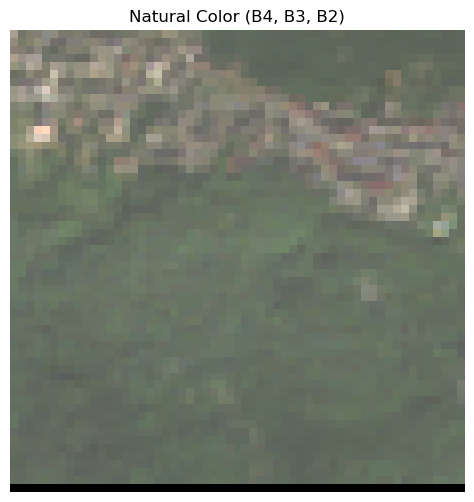

In [23]:
from matplotlib import pyplot as plt
import os
import rasterio
import numpy as np

tilefile = os.path.join(train_img_folder, 'row80-col64.tif')
naip_dataset = rasterio.open(tilefile)
naip_img = naip_dataset.read()  # shape: (bands, height, width)
naip_img = naip_img.transpose(1, 2, 0)  # (height, width, bands)

# 取 RGB 波段（B04, B03, B02）
rgb_img = naip_img[:, :, [2, 1, 0]]  # R=Band4, G=Band3, B=Band2

# 简单归一化到 0~1 区间
rgb_img = rgb_img.astype(np.float32)
rgb_img /= rgb_img.max()

plt.figure(figsize=(6, 6))
plt.imshow(rgb_img)
plt.title("Natural Color (B4, B3, B2)")
plt.axis('off')
plt.show()


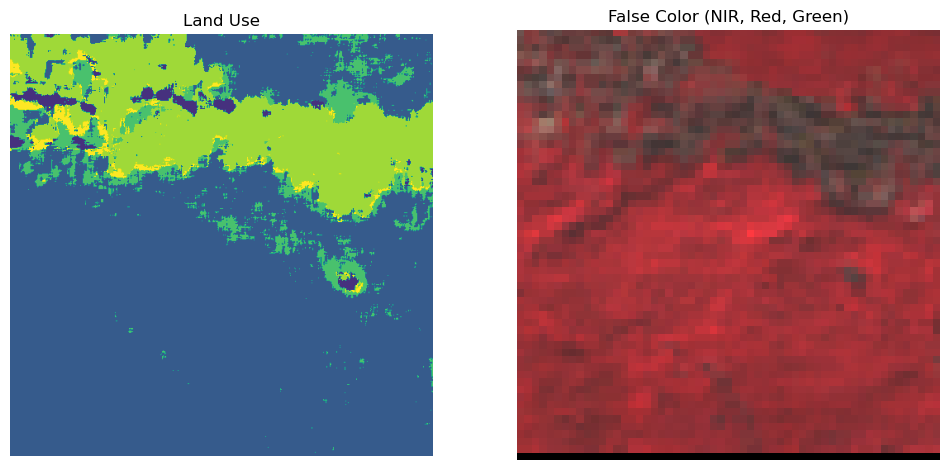

In [24]:
import numpy as np
from matplotlib import pyplot as plt

# 提取假彩色波段：NIR (B08), Red (B04), Green (B03)
naip_falsecolor = naip_img[:, :, [3, 2, 1]].astype(np.float32)

# 简单 min-max 归一化到 0~1 范围
naip_falsecolor_norm = (naip_falsecolor - naip_falsecolor.min()) / (naip_falsecolor.max() - naip_falsecolor.min())
naip_falsecolor_norm = np.clip(naip_falsecolor_norm, 0, 1)

f, axarr = plt.subplots(1, 2, figsize=(12, 12)) 
axarr[0].imshow(lu_img) 
axarr[0].set_title('Land Use')
axarr[0].axis('off')

axarr[1].imshow(naip_falsecolor_norm)
axarr[1].set_title('False Color (NIR, Red, Green)')
axarr[1].axis('off')

plt.show()

In [14]:
# 3. Split the dataset into training and testing

In [25]:
def split_train_validate(training_img_dir, training_labels_dir, validation_img_dir, validation_labels_dir, split = 5):
    '''split the training dataset into training and validationg parts, randomly
    select 20% of the training datast (imgs and labels) into the validation folder
    '''
    ## split the train dataset and validation dataset
    img_sample = random.sample(Path(training_img_dir).files(), len(Path(training_img_dir).files())//split )

    if not os.path.exists(validation_img_dir): os.mkdir(validation_img_dir)
    if not os.path.exists(validation_labels_dir): os.mkdir(validation_labels_dir)

    for i in img_sample:
        from_img_name = os.path.join(training_img_dir, i.name)
        shutil.move(os.path.join(training_img_dir, i.name), os.path.join(validation_img_dir, i.name))
        shutil.move(os.path.join(training_labels_dir, i.name), os.path.join(validation_labels_dir, i.name))
    

In [26]:
# the validataon folder
folder1 = 'data/dataset'
valid_folder = os.path.join(folder1, 'validation')
if not os.path.exists(valid_folder): os.mkdir(valid_folder)
valid_label_folder = os.path.join(valid_folder, 'labels')
if not os.path.exists(valid_label_folder): os.mkdir(valid_label_folder)
valid_img_folder = os.path.join(valid_folder, 'imgs')
if not os.path.exists(valid_img_folder): os.mkdir(valid_img_folder)

split_train_validate(train_img_folder, train_label_folder, valid_img_folder, valid_label_folder)

In [27]:
file = '../data/dataset/trainning/labels/row80-col64.tif'

os.path.exists(file)

False